# OBJECTIVE OF THIS NOTEBOOK

In this notebook we want to have a look on the clicks table in the last two months. 

## Understanding Why referer_host Is Missing
Clicks without a referer_host usually happen due to:
- Direct Traffic (e.g., users typing the URL or clicking from emails/apps).
- Privacy Restrictions (e.g., HTTPS to HTTP transitions).
- Blocked by Browser Settings (some browsers strip referral data).
- Mobile Apps & Messengers (e.g., Instagram, WhatsApp don’t always pass referrer info).

### 1. **Click Performance Analysis**

- Click trends over time (`created_at`): Identify peak hours, days, or seasonal trends.
- Clicks per `product_link_id`: Find the most clicked product links.
- Clicks per `source_id`: Identify the most effective brands.
### 2. **Traffic Source Analysis**

- Clicks by `referer_host`: Understand which platforms drive the most traffic (e.g., Instagram, Twitter).
- Clicks by `ip_country`: Identify top-performing regions for each brand.
- Clicks by `foreign_country`: Measure international traffic.
### 3. **Fraud Detection**

- Clicks per `ip`: Detect potential bot activity or unusual click patterns.
- Clicks per `user_agent`: Spot excessive clicks from the same device/browser.
- Clicks per second/minute per `product_link_id`: Identify spikes that may indicate fraudulent activity.
### 4. **Geographic Insights**

- Click distribution heatmap by `ip_country`.
- Conversion rates by `ip_country` (if sales data is available)

### 5. **Referral Analysis**

- Click conversion by `referer`: Identify high-quality traffic sources.
- Click distribution per `referer_host`: Find out which social media or websites perform best.

In [155]:
import warnings
warnings.simplefilter('ignore')

import datetime as dt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100
import seaborn as sns
sns.set()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [156]:
#importing the data into a pandas data frame
raw_clicks_df = pd.read_csv("data/clicks.csv", sep=',')

#create working copy of the raw data
clicks_df = raw_clicks_df.copy()

In [157]:
clicks_df.columns

Index(['_AIRBYTE_RAW_ID', '_AIRBYTE_EXTRACTED_AT', '_AIRBYTE_META', 'ID', 'IP', 'CPC', 'TARGET', 'REFERER', 'ACTOR_ID', 'CURRENCY', 'PROCESSED', 'SOURCE_ID', 'ACTOR_TYPE', 'CREATED_AT', 'IP_COUNTRY', 'UPDATED_AT', 'USER_AGENT', '_AB_CDC_LSN', 'REFERER_HOST', 'CLASSIFICATION', 'FOREIGN_COUNTRY', 'PRODUCT_LINK_ID', '_AB_CDC_DELETED_AT', '_AB_CDC_UPDATED_AT'], dtype='object')

id - id number; actor_id - actor ID (light user id); product_link_id; created_at - time when the clicks were created (date and time); updated_at - time when the clicks were updated (date and time); user_agent - device of the click; ip - ip address; ip_country-country abbreviation;referer - link referer; actor_type	- [NULL], LightUser (Instagram); source_id-network, shop, country; currency - currency of the cpc; target - target_host	stylink, linkmaker, webestats...

In [158]:
# choose only the columns we want to consider
clicks_df = clicks_df[['ID', 'PRODUCT_LINK_ID', 'SOURCE_ID', 'CPC', 'CURRENCY', 'ACTOR_ID', 'ACTOR_TYPE', 'IP','IP_COUNTRY','FOREIGN_COUNTRY','USER_AGENT','REFERER', 'REFERER_HOST', 'PROCESSED', 'CREATED_AT']]

In [159]:
clicks_df.head()

,ID,PRODUCT_LINK_ID,SOURCE_ID,CPC,CURRENCY,ACTOR_ID,ACTOR_TYPE,IP,IP_COUNTRY,FOREIGN_COUNTRY,USER_AGENT,REFERER,REFERER_HOST,PROCESSED,CREATED_AT
0,623979187,5418289,rakuten-hm-pl,0.0,PLN,290449014.0,LightUser,188.241.25.30,pl,False,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,NaN,NaN,False,2025-03-26 12:23:02.000
1,623979186,5417799,amazon-uk,3.0,EUR,NaN,NaN,86.45.106.142,ie,False,Mozilla/5.0 (Linux; Android 14; SM-G991B Build...,https://www.stylist.social/,stylist,False,2025-03-26 12:23:02.000
2,623979185,5416047,amazon-de,7.0,EUR,290448983.0,LightUser,185.131.74.168,de,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like...,https://app.stylink.com/ref_ios/redir/32YYmiJV...,stylink,False,2025-03-26 12:23:02.000
3,623979184,5418504,amazon-uk,5.0,GBP,290447611.0,LightUser,188.30.133.168,gb,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like...,https://app.stylink.com/ref_ios/redir/L4lQhl7B...,stylink,False,2025-03-26 12:23:02.000
4,623979183,5418042,rakuten-hm-de,11.0,EUR,290449008.0,LightUser,178.115.44.179,at,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_1 like M...,https://app.stylink.com/ref_ios/redir/DQq9AS9l...,stylink,False,2025-03-26 12:23:02.000


In [160]:
#Let's have a look at the shep of our dataset, meaning how long and wide it is
clicks_df.shape

(9152400, 15)

We have 9.152.400 rows and 14 columns in our dataset.

In [161]:
# we now want to check our data-types
clicks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9152400 entries, 0 to 9152399
Data columns (total 15 columns):
 #   Column           Dtype  
---  ------           -----  
 0   ID               int64  
 1   PRODUCT_LINK_ID  int64  
 2   SOURCE_ID        object 
 3   CPC              float64
 4   CURRENCY         object 
 5   ACTOR_ID         float64
 6   ACTOR_TYPE       object 
 7   IP               object 
 8   IP_COUNTRY       object 
 9   FOREIGN_COUNTRY  object 
 10  USER_AGENT       object 
 11  REFERER          object 
 12  REFERER_HOST     object 
 13  PROCESSED        bool   
 14  CREATED_AT       object 
dtypes: bool(1), float64(2), int64(2), object(10)
memory usage: 986.3+ MB


In [162]:
#check for duplicate rows in product_link_id column
clicks_df['PRODUCT_LINK_ID'].duplicated().value_counts()

True     8930179
False     222221
Name: PRODUCT_LINK_ID, dtype: int64

So we have data on 222.221 product links to analyse. In our database, the same link can appear multiple times (also clicks can appear more than on one day).

In [163]:
#check how many duplicated rows exist in the data frame
no_of_dups = clicks_df.duplicated().sum()
print("number of rows having complete row duplicate :", no_of_dups)

number of rows having complete row duplicate : 0


In [164]:
#check for null values
clicks_df.isna().sum()

ID                       0
PRODUCT_LINK_ID          0
SOURCE_ID                5
CPC                    193
CURRENCY               193
ACTOR_ID           1099602
ACTOR_TYPE         1099602
IP                       0
IP_COUNTRY             595
FOREIGN_COUNTRY        595
USER_AGENT             546
REFERER            2896551
REFERER_HOST       2896553
PROCESSED                0
CREATED_AT               0
dtype: int64

In [165]:
#check number of unique values in the dataset
for i in list(clicks_df[['SOURCE_ID', 'IP', 'USER_AGENT', 'REFERER', 'REFERER_HOST']]):
    print(f'Unique {i}: {clicks_df[i].nunique()}')

Unique SOURCE_ID: 2089
Unique IP: 3310129
Unique USER_AGENT: 85591
Unique REFERER: 5611509
Unique REFERER_HOST: 459


In [166]:
clicks_df['CREATED_AT'] = pd.to_datetime(clicks_df['CREATED_AT'])

In [167]:
#check time range of the dataset
print(f"Min Date Link: {clicks_df['CREATED_AT'].min()}")
print(f"Max Date Link: {clicks_df['CREATED_AT'].max()}")

Min Date Link: 2025-03-02 00:00:00
Max Date Link: 2025-03-26 12:23:02


In [168]:
data_df = clicks_df.assign(
    click_date = lambda x: x['CREATED_AT'].dt.date,
    click_day = lambda x: x['CREATED_AT'].dt.day,
    click_day_of_week = lambda x: x['CREATED_AT'].dt.dayofweek,
    click_hour = lambda x: x['CREATED_AT'].dt.hour
)

Note: It is assumed the week starts on Monady, which is denoted by 0 and ends on Sunday which is denoted by 6.

In [169]:
data_df.head()

,ID,PRODUCT_LINK_ID,SOURCE_ID,CPC,CURRENCY,ACTOR_ID,ACTOR_TYPE,IP,IP_COUNTRY,FOREIGN_COUNTRY,USER_AGENT,REFERER,REFERER_HOST,PROCESSED,CREATED_AT,click_date,click_day,click_day_of_week,click_hour
0,623979187,5418289,rakuten-hm-pl,0.0,PLN,290449014.0,LightUser,188.241.25.30,pl,False,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,NaN,NaN,False,2025-03-26 12:23:02,2025-03-26,26,2,12
1,623979186,5417799,amazon-uk,3.0,EUR,NaN,NaN,86.45.106.142,ie,False,Mozilla/5.0 (Linux; Android 14; SM-G991B Build...,https://www.stylist.social/,stylist,False,2025-03-26 12:23:02,2025-03-26,26,2,12
2,623979185,5416047,amazon-de,7.0,EUR,290448983.0,LightUser,185.131.74.168,de,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like...,https://app.stylink.com/ref_ios/redir/32YYmiJV...,stylink,False,2025-03-26 12:23:02,2025-03-26,26,2,12
3,623979184,5418504,amazon-uk,5.0,GBP,290447611.0,LightUser,188.30.133.168,gb,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like...,https://app.stylink.com/ref_ios/redir/L4lQhl7B...,stylink,False,2025-03-26 12:23:02,2025-03-26,26,2,12
4,623979183,5418042,rakuten-hm-de,11.0,EUR,290449008.0,LightUser,178.115.44.179,at,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_1 like M...,https://app.stylink.com/ref_ios/redir/DQq9AS9l...,stylink,False,2025-03-26 12:23:02,2025-03-26,26,2,12


In [170]:
data_df['weekend'] = data_df.click_date.isin([5,6])
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
data_df['weekday'] = data_df.click_day_of_week.map(dayOfWeek)

In [171]:
#weekday
weekday_clicks_df = data_df.groupby("weekday")['ID'].nunique().sort_values(ascending=False).to_frame().reset_index()
weekday_clicks_df.columns = ["weekday", "total_clicks"]
weekday_clicks_df.head(20)

,weekday,total_clicks
0,Sunday,1621943
1,Tuesday,1452652
2,Monday,1355038
3,Wednesday,1243292
4,Saturday,1189886
5,Friday,1173199
6,Thursday,1116390


[Text(0.5, 1.0, 'Clicks by Weekday'),
 Text(0.5, 0, 'Weekday'),
 Text(0, 0.5, 'Total Clicks')]

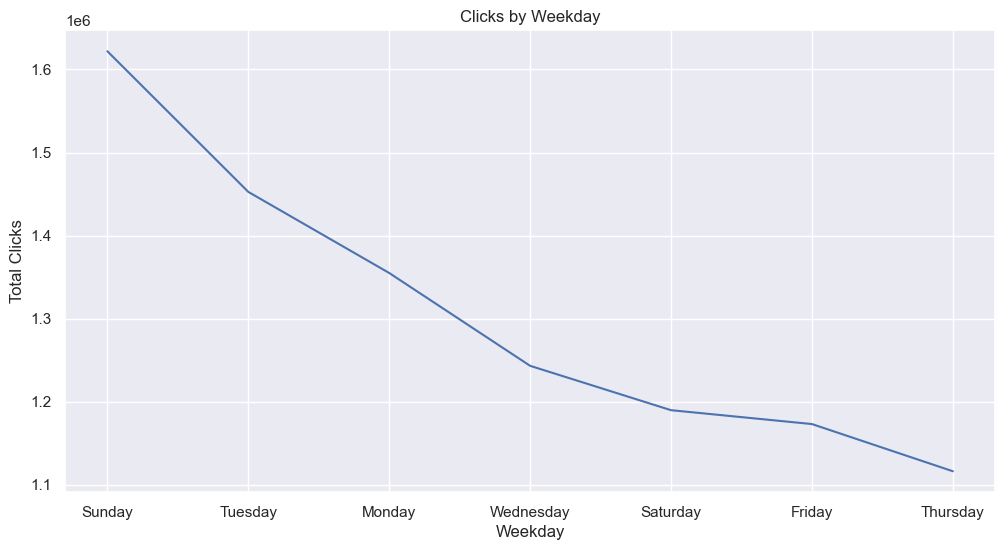

In [172]:
fig, ax = plt.subplots()
sns.lineplot(x='weekday', y='total_clicks', data=weekday_clicks_df.reset_index(), ax=ax)
ax.set(title="Clicks by Weekday", xlabel='Weekday', ylabel='Total Clicks')

In [173]:
clicks_hour_df = data_df.groupby("click_hour")['ID'].nunique().sort_values(ascending=False).to_frame().reset_index()
clicks_hour_df.columns = ["hour", "total_clicks"]
clicks_hour_df.head(20)

,hour,total_clicks
0,20,772758
1,19,727805
2,21,656142
3,18,591363
4,11,456507
5,12,452585
6,17,444770
7,8,440380
8,16,437993
9,9,432254


[Text(0.5, 1.0, 'Clicks by Hour'),
 Text(0.5, 0, 'Hour'),
 Text(0, 0.5, 'Total Clicks')]

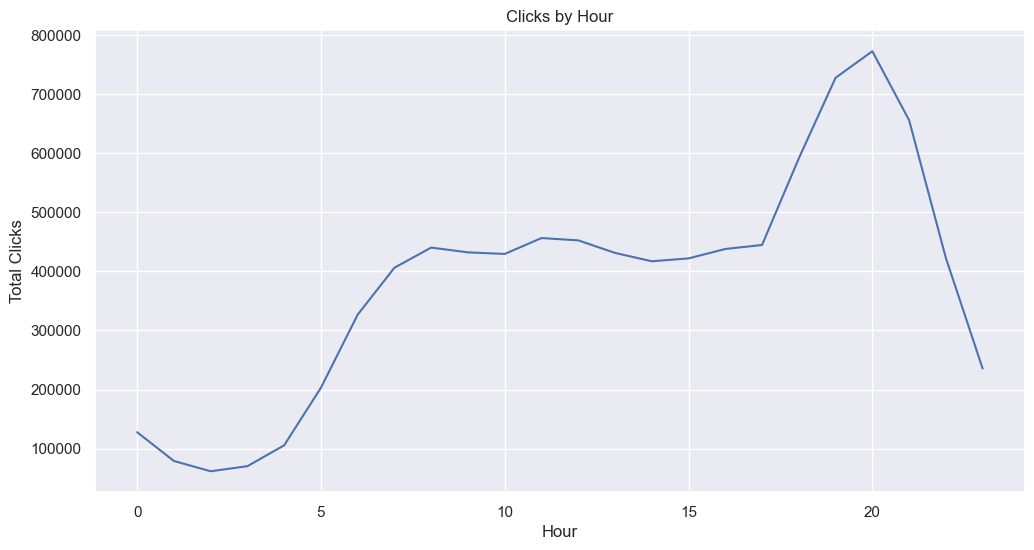

In [174]:
fig, ax = plt.subplots()
sns.lineplot(x='hour', y='total_clicks', data=clicks_hour_df.reset_index(), ax=ax)
ax.set(title="Clicks by Hour", xlabel='Hour', ylabel='Total Clicks')

In [175]:
source_clicks_df = data_df.groupby("SOURCE_ID")['ID'].nunique().sort_values(ascending=False).to_frame().reset_index()
source_clicks_df.columns = ["SOURCE_ID", "total_clicks"]
source_clicks_df.head(10)

,SOURCE_ID,total_clicks
0,rakuten-hm-de,1788377
1,amazon-de,1375788
2,rakuten-hmvip-de,462831
3,rakuten-hm-uk,367273
4,rakuten-nl-hm-nl,331245
5,private-otto,294912
6,amazon-uk,251071
7,impact-asos-de,234384
8,rakuten-hmvip-pl,228505
9,rakuten-hm-pl,185897


In [176]:
source_clicks_links_df = data_df.groupby("SOURCE_ID")['PRODUCT_LINK_ID'].nunique().sort_values(ascending=False).to_frame().reset_index()
source_clicks_links_df.columns = ["SOURCE_ID", "total_link_clicks"]
source_clicks_links_df.head(10)

,SOURCE_ID,total_link_clicks
0,rakuten-hm-de,41814
1,amazon-de,24333
2,rakuten-hm-uk,11202
3,private-otto,7346
4,impact-asos-de,7021
5,impact-uk-asos-uk,6156
6,amazon-uk,5330
7,rakuten-hmvip-de,4324
8,rakuten-nl-hm-nl,4275
9,rakuten-hm-pl,4150


#### Total clicked product link ids

In [177]:
pr_lnk_df = data_df.groupby("PRODUCT_LINK_ID")['ID'].nunique().sort_values(ascending=False).to_frame().reset_index()
pr_lnk_df.columns = ["PRODUCT_LINK_ID", "total_clicks"]
pr_lnk_df.head(10)

,PRODUCT_LINK_ID,total_clicks
0,5401034,38202
1,5412145,22650
2,5374017,19867
3,5332462,19548
4,5378253,19083
5,5348939,17664
6,5341128,14723
7,5344814,14331
8,5348399,13633
9,5379111,13549


#### Clicks by Refer Host

In [178]:
print(data_df.REFERER_HOST.nunique())

459


In [179]:
ref_host_df = data_df.groupby("REFERER_HOST")['ID'].nunique().sort_values(ascending=False).to_frame().reset_index()
ref_host_df.columns = ["REFERER_HOST", "total_clicks"]
ref_host_df.head(10)

,REFERER_HOST,total_clicks
0,stylink,5794888
1,instagram,155372
2,youtube,95520
3,facebook,78139
4,stylist,36659
5,pinterest,18572
6,linktr,11243
7,mittlivpalandet,11227
8,minimalissmo,6649
9,diski,5637


### Clicks Over Time for Topn N `referer_host`

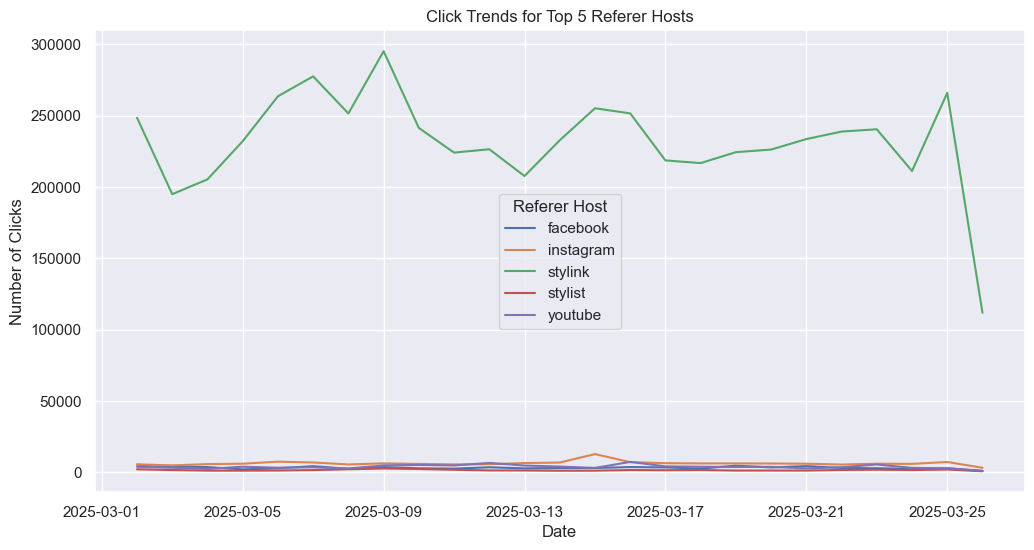

In [180]:
def plot_top_referers(df, top_n=5):
    # Count total clicks per referer_host
    top_referers = df['REFERER_HOST'].value_counts().head(top_n).index
    
    # Filter dataset for only the top referers
    filtered_df = df[df['REFERER_HOST'].isin(top_referers)]
    
    # Group by date and referer_host
    clicks_per_day = filtered_df.groupby(['click_date', 'REFERER_HOST']).size().unstack().fillna(0)
    
    # Plot
    clicks_per_day.plot(kind='line', figsize=(12, 6))
    plt.xlabel("Date")
    plt.ylabel("Number of Clicks")
    plt.title(f"Click Trends for Top {top_n} Referer Hosts")
    plt.legend(title="Referer Host")
    plt.show()

# Example usage
plot_top_referers(data_df)

### Clicks by Stylink vs. Social Media vs. Search Engines

In [181]:
def categorize_referers(df):
    stylist_media = ['stylist']
    stylink_media = ['stylink']
    social_media = ['facebook', 'instagram', 'twitter', 'linkedin', 'pinterest', 'tiktok', 'snapchat', 'reddit']
    search_engines = ['google', 'bing', 'yahoo', 'duckduckgo']

    df['referer_category'] = 'Other'
    df.loc[df['REFERER_HOST'].isin(stylist_media), 'referer_category'] = 'Stylist'
    df.loc[df['REFERER_HOST'].isin(stylink_media), 'referer_category'] = 'Stylink'
    df.loc[df['REFERER_HOST'].isin(social_media), 'referer_category'] = 'Social Media'
    df.loc[df['REFERER_HOST'].isin(search_engines), 'referer_category'] = 'Search Engine'

    return df

# Example usage
df = categorize_referers(data_df)
print(df['referer_category'].value_counts())

Stylnik          5794888
Other            3062088
Social Media      254783
Stylist            36659
Search Engine       3982
Name: referer_category, dtype: int64


#### Clicks by IP

In [182]:
ip_df = data_df.groupby("IP")['ID'].nunique().sort_values(ascending=False).to_frame().reset_index()
ip_df.columns = ["IP", "total_clicks"]
ip_df.head(10)

,IP,total_clicks
0,49.13.129.56,26671
1,46.4.97.80,13586
2,104.28.62.24,13299
3,104.28.62.25,8456
4,104.28.30.74,5525
5,104.28.62.43,5433
6,104.28.30.75,5015
7,104.28.62.32,4463
8,104.28.62.57,4345
9,104.28.62.41,4243


#### Clicks by IP country

In [183]:
data_df.columns

Index(['ID', 'PRODUCT_LINK_ID', 'SOURCE_ID', 'CPC', 'CURRENCY', 'ACTOR_ID', 'ACTOR_TYPE', 'IP', 'IP_COUNTRY', 'FOREIGN_COUNTRY', 'USER_AGENT', 'REFERER', 'REFERER_HOST', 'PROCESSED', 'CREATED_AT', 'click_date', 'click_day', 'click_day_of_week', 'click_hour', 'weekend', 'weekday', 'referer_category'], dtype='object')

In [184]:
ip_country_df = data_df.groupby("IP_COUNTRY")['ID'].nunique().sort_values(ascending=False).to_frame().reset_index()
ip_country_df.columns = ["IP_COUNTRY", "total_clicks"]
ip_country_df.head(20)

,IP_COUNTRY,total_clicks
0,de,4670433
1,gb,1334643
2,pl,890265
3,nl,538459
4,at,343532
5,fr,205463
6,us,187023
7,ch,183573
8,ie,174037
9,be,81329


#### Clicks by foreign country

In [185]:
foreign_country_df = data_df.groupby("FOREIGN_COUNTRY")['ID'].nunique().sort_values(ascending=False).to_frame().reset_index()
foreign_country_df.columns = ["FOREIGN_COUNTRY", "total_clicks"]
foreign_country_df.head(20)

,FOREIGN_COUNTRY,total_clicks
0,False,8122266
1,True,1029539


#### User Agent

In [186]:
user_agent_df = data_df.groupby("USER_AGENT")['ID'].nunique().sort_values(ascending=False).to_frame().reset_index()
user_agent_df.columns = ["USER_AGENT", "total_clicks"]
user_agent_df.head(20)

,USER_AGENT,total_clicks
0,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like...,2415531
1,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like...,1307662
2,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,1116408
3,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,620069
4,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,543816
5,Mozilla/5.0 (iPhone; CPU iPhone OS 18_1_1 like...,343328
6,Mozilla/5.0 (iPhone; CPU iPhone OS 17_6_1 like...,337316
7,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like...,183911
8,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like...,163763
9,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like...,123968


## Fraud Detection 

Fraud detection in click data can be done by identifying anomalous patterns, such as excessive clicks from the same IP, rapid clicks in a short period, or unusual user_agent behavior.

### Detecting Unusual Traffic Sources
If we suspect bot traffic, look for unusual or unknown referrers.

We flag referrers that have an unusually low number of clicks, as these might be bots or anomalies. Flags referer_host values with fewer than 5 clicks (adjustable).These might be bots or fraudulent sources.

In [187]:
def detect_unusual_referers(df, threshold=5):
    referer_counts = df['REFERER_HOST'].value_counts()
    unusual_referers = referer_counts[referer_counts < threshold].index
    df['fraud_suspicious_referer'] = df['REFERER_HOST'].isin(unusual_referers)
    return df

df = detect_unusual_referers(data_df)
suspicious_referer_df = df[df['fraud_suspicious_referer']]
print(suspicious_referer_df.head(10))
print(suspicious_referer_df.REFERER_HOST.nunique())
print(suspicious_referer_df.REFERER_HOST.unique())

               ID  PRODUCT_LINK_ID           SOURCE_ID  CPC CURRENCY  ACTOR_ID ACTOR_TYPE              IP IP_COUNTRY FOREIGN_COUNTRY                                         USER_AGENT                                            REFERER        REFERER_HOST  PROCESSED          CREATED_AT  click_date  click_day  click_day_of_week  click_hour  weekend    weekday referer_category  fraud_suspicious_referer
81582   623897610          3467636        private-otto  0.0      EUR       NaN        NaN     212.3.80.50         de           False  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...  https://25399044.hubspotpreview-eu1.com/_hcms/...  hubspotpreview-eu1       True 2025-03-26 08:55:17  2025-03-26         26                  2           8    False  Wednesday            Other                      True
111026  623868162          4360154      impact-temu-nl  1.0      EUR       NaN        NaN  178.85.243.146         nl           False  Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like...           

In [188]:
wth_actor_df = data_df.query('ACTOR_ID.isnull()')
wth_actor_df.head(10)

,ID,PRODUCT_LINK_ID,SOURCE_ID,CPC,CURRENCY,ACTOR_ID,ACTOR_TYPE,IP,IP_COUNTRY,FOREIGN_COUNTRY,USER_AGENT,REFERER,REFERER_HOST,PROCESSED,CREATED_AT,click_date,click_day,click_day_of_week,click_hour,weekend,weekday,referer_category,fraud_suspicious_referer
1,623979186,5417799,amazon-uk,3.0,EUR,NaN,NaN,86.45.106.142,ie,False,Mozilla/5.0 (Linux; Android 14; SM-G991B Build...,https://www.stylist.social/,stylist,False,2025-03-26 12:23:02,2025-03-26,26,2,12,False,Wednesday,Stylist,False
10,623979179,5414877,amazon-pl,1.0,PLN,NaN,NaN,37.31.18.135,pl,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like...,https://app.stylink.com/ref_ios/redir/DQRnmF9l...,stylink,False,2025-03-26 12:23:01,2025-03-26,26,2,12,False,Wednesday,Stylnik,False
12,623979180,5252984,rakuten-uk-urban-outfitters-uk,1.0,EUR,NaN,NaN,112.197.233.43,vn,True,Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build...,NaN,NaN,False,2025-03-26 12:23:01,2025-03-26,26,2,12,False,Wednesday,Other,False
20,623979173,4348479,awin-stradivarius-de,1.0,EUR,NaN,NaN,89.247.32.44,de,False,Mozilla/5.0 (iPhone; CPU iPhone OS 16_4_1 like...,https://www.stylist.social/,stylist,False,2025-03-26 12:23:00,2025-03-26,26,2,12,False,Wednesday,Stylist,False
25,623979159,5380917,rakuten-hm-de,8.0,EUR,NaN,NaN,46.234.240.174,it,True,Mozilla/5.0 (Linux; Android 13; M2103K19G Buil...,http://m.facebook.com/,facebook,False,2025-03-26 12:22:59,2025-03-26,26,2,12,False,Wednesday,Social Media,False
26,623979160,2762700,rakuten-hm-de,8.0,EUR,NaN,NaN,81.220.93.0,fr,True,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like...,NaN,NaN,False,2025-03-26 12:22:59,2025-03-26,26,2,12,False,Wednesday,Other,False
30,623979156,5418289,rakuten-hm-pl,0.0,PLN,NaN,NaN,77.222.245.191,pl,False,Mozilla/5.0 (Linux; Android 13; CPH2343 Build/...,http://m.facebook.com/,facebook,False,2025-03-26 12:22:58,2025-03-26,26,2,12,False,Wednesday,Social Media,False
34,623979154,5252990,rakuten-uk-urban-outfitters-uk,1.0,EUR,NaN,NaN,88.147.189.226,ru,True,Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build...,NaN,NaN,False,2025-03-26 12:22:58,2025-03-26,26,2,12,False,Wednesday,Other,False
42,623979148,4955613,stylink-stylink-uk,0.0,GBP,NaN,NaN,92.40.193.141,gb,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_2 like M...,https://app.stylink.com/ref_ios/redir/3Z7XoFJN...,stylink,False,2025-03-26 12:22:57,2025-03-26,26,2,12,False,Wednesday,Stylnik,False
43,623979135,5415888,rakuten-hm-de,8.0,EUR,NaN,NaN,154.194.23.126,us,True,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,NaN,NaN,False,2025-03-26 12:22:56,2025-03-26,26,2,12,False,Wednesday,Other,False


In [189]:
data_df.ACTOR_TYPE.unique()

array(['LightUser', nan, 'User'], dtype=object)

In [190]:
data_df.query("ACTOR_TYPE=='User'")

,ID,PRODUCT_LINK_ID,SOURCE_ID,CPC,CURRENCY,ACTOR_ID,ACTOR_TYPE,IP,IP_COUNTRY,FOREIGN_COUNTRY,USER_AGENT,REFERER,REFERER_HOST,PROCESSED,CREATED_AT,click_date,click_day,click_day_of_week,click_hour,weekend,weekday,referer_category,fraud_suspicious_referer
6348,623972841,5165548,digidip-tui-uk,7.0,GBP,65932.0,User,86.175.122.20,gb,False,Mozilla/5.0 (iPhone; CPU iPhone OS 17_6_1 like...,https://app.stylink.com/ref_ios/redir/YAegTyLA...,stylink,True,2025-03-26 12:09:21,2025-03-26,26,2,12,False,Wednesday,Stylnik,False
6436,623972754,5165548,digidip-tui-uk,7.0,GBP,65932.0,User,86.175.122.20,gb,False,Mozilla/5.0 (iPhone; CPU iPhone OS 17_6_1 like...,https://app.stylink.com/ref_ios/redir/YAegTyLA...,stylink,True,2025-03-26 12:09:09,2025-03-26,26,2,12,False,Wednesday,Stylnik,False
7144,623972041,5418463,rakuten-hmvip-pl,15.0,PLN,167354.0,User,94.254.145.87,pl,False,Mozilla/5.0 (iPhone; CPU iPhone OS 17_6_1 like...,https://app.stylink.com/ref_ios/redir/5YjpyFwP...,stylink,True,2025-03-26 12:07:37,2025-03-26,26,2,12,False,Wednesday,Stylnik,False
11119,623968068,5418235,rakuten-hm-de,11.0,EUR,161749.0,User,80.187.67.82,de,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like...,https://app.stylink.com/ref_ios/redir/q2R6YS3M...,stylink,True,2025-03-26 11:59:41,2025-03-26,26,2,11,False,Wednesday,Stylnik,False
11355,623967834,5418078,rakuten-hm-de,11.0,EUR,161749.0,User,80.187.67.82,de,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like...,https://app.stylink.com/ref_ios/redir/QPdXbHGD...,stylink,True,2025-03-26 11:59:14,2025-03-26,26,2,11,False,Wednesday,Stylnik,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9115371,614863816,5330315,private-otto,6.0,EUR,255418.0,User,94.134.111.164,de,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like...,https://app.stylink.com/ref_ios/redir/OxvdBtzo...,stylink,True,2025-03-02 07:38:27,2025-03-02,2,6,7,False,Sunday,Stylnik,False
9117104,614862079,5330906,rakuten-hm-uk,6.0,GBP,194052.0,User,172.226.116.51,es,True,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like...,https://app.stylink.com/ref_ios/redir/DQJvJs9x...,stylink,True,2025-03-02 07:30:36,2025-03-02,2,6,7,False,Sunday,Stylnik,False
9134383,614844804,5330599,amazon-de,1.0,EUR,271467.0,User,88.130.48.205,de,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like...,https://app.stylink.com/ref_ios/redir/ZN9PhpB7...,stylink,True,2025-03-02 04:57:01,2025-03-02,2,6,4,False,Sunday,Stylnik,False
9139761,614839426,4101871,private-home24-de,2.0,EUR,190394.0,User,91.17.214.36,de,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like...,https://app.stylink.com/ref_ios/redir/X54bvI5g...,stylink,True,2025-03-02 03:05:12,2025-03-02,2,6,3,False,Sunday,Stylnik,False


In [191]:
user_agent_all_df = data_df.groupby("USER_AGENT")['ID'].nunique().sort_values(ascending=False).to_frame().reset_index()
user_agent_all_df.columns = ["USER_AGENT", "total_clicks"]
user_agent_all_df.head(10)

,USER_AGENT,total_clicks
0,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like...,2415531
1,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like...,1307662
2,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,1116408
3,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,620069
4,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,543816
5,Mozilla/5.0 (iPhone; CPU iPhone OS 18_1_1 like...,343328
6,Mozilla/5.0 (iPhone; CPU iPhone OS 17_6_1 like...,337316
7,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like...,183911
8,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like...,163763
9,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like...,123968


### Comparing CPC Effectiveness per Source ID

In [192]:
def analyze_cpc_by_source(df):
    cpc_analysis = df.groupby('SOURCE_ID').agg(
        total_clicks=('ID', 'count'),
        avg_cpc=('CPC', 'mean'),
        total_cpc_spent=('CPC', 'sum')
    ).sort_values(by='total_cpc_spent', ascending=False)
    
    return cpc_analysis

cpc_report = analyze_cpc_by_source(data_df)
print(cpc_report)

                         total_clicks    avg_cpc  total_cpc_spent
SOURCE_ID                                                        
rakuten-hm-de                 1788377   6.371629       11394818.0
amazon-de                     1375788   3.690397        5077200.0
rakuten-hmvip-de               462831  10.285862        4760616.0
rakuten-hmvip-pl               228505  12.772495        2918579.0
rakuten-nl-hm-nl               331245   5.980045        1980854.0
...                               ...        ...              ...
external-inuikii-at                 5   0.000000              0.0
external-intimissimi-de             5   0.000000              0.0
external-instagram-gb               1   0.000000              0.0
external-instagram-de              47   0.000000              0.0
external-klekks-de                  3   0.000000              0.0

[2089 rows x 3 columns]


# Missing Referer Host

In [193]:
missing_rh_df = data_df.query('REFERER_HOST.isnull()')
missing_rh_df.head()

,ID,PRODUCT_LINK_ID,SOURCE_ID,CPC,CURRENCY,ACTOR_ID,ACTOR_TYPE,IP,IP_COUNTRY,FOREIGN_COUNTRY,USER_AGENT,REFERER,REFERER_HOST,PROCESSED,CREATED_AT,click_date,click_day,click_day_of_week,click_hour,weekend,weekday,referer_category,fraud_suspicious_referer
0,623979187,5418289,rakuten-hm-pl,0.0,PLN,290449014.0,LightUser,188.241.25.30,pl,False,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,NaN,NaN,False,2025-03-26 12:23:02,2025-03-26,26,2,12,False,Wednesday,Other,False
5,623979181,5418463,rakuten-hmvip-pl,15.0,PLN,288348545.0,LightUser,89.64.230.72,pl,False,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,NaN,NaN,False,2025-03-26 12:23:02,2025-03-26,26,2,12,False,Wednesday,Other,False
11,623979175,5415442,amazon-de,7.0,EUR,290448998.0,LightUser,89.244.87.29,de,False,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,NaN,NaN,False,2025-03-26 12:23:01,2025-03-26,26,2,12,False,Wednesday,Other,False
12,623979180,5252984,rakuten-uk-urban-outfitters-uk,1.0,EUR,NaN,NaN,112.197.233.43,vn,True,Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build...,NaN,NaN,False,2025-03-26 12:23:01,2025-03-26,26,2,12,False,Wednesday,Other,False
14,623979171,5414174,tradedoubler-bonprix-pl,15.0,PLN,277866222.0,LightUser,91.94.117.4,pl,False,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,NaN,NaN,False,2025-03-26 12:23:00,2025-03-26,26,2,12,False,Wednesday,Other,False


In [194]:
pr_lnk_df = missing_rh_df.groupby("SOURCE_ID")['ID'].nunique().sort_values(ascending=False).to_frame().reset_index()
pr_lnk_df.columns = ["SOURCE_ID", "total_clicks"]
pr_lnk_df.head(10)

,SOURCE_ID,total_clicks
0,amazon-de,495473
1,rakuten-hm-de,489690
2,rakuten-hmvip-pl,101500
3,private-otto,98520
4,rakuten-hmvip-de,98335
5,rakuten-nl-hm-nl,92562
6,rakuten-hm-pl,89275
7,amazon-uk,82871
8,rakuten-hm-uk,78114
9,impact-asos-de,63951


In [195]:
ip_country_df = missing_rh_df.groupby("IP_COUNTRY")['ID'].nunique().sort_values(ascending=False).to_frame().reset_index()
ip_country_df.columns = ["IP_COUNTRY", "total_clicks"]
ip_country_df.head(10)

,IP_COUNTRY,total_clicks
0,de,1405834
1,pl,412154
2,gb,305067
3,nl,147715
4,us,114177
5,at,101938
6,ie,84103
7,fr,65397
8,ch,39097
9,ru,24700


In [196]:
pr_lnk_df = missing_rh_df.groupby("SOURCE_ID")['ID'].nunique().sort_values(ascending=False).to_frame().reset_index()
pr_lnk_df.columns = ["SOURCE_ID", "total_clicks"]
pr_lnk_df.head(10)

,SOURCE_ID,total_clicks
0,amazon-de,495473
1,rakuten-hm-de,489690
2,rakuten-hmvip-pl,101500
3,private-otto,98520
4,rakuten-hmvip-de,98335
5,rakuten-nl-hm-nl,92562
6,rakuten-hm-pl,89275
7,amazon-uk,82871
8,rakuten-hm-uk,78114
9,impact-asos-de,63951


## Why `referer_host` is empty?
Direct Traffic (e.g., users typing the URL or clicking from emails/apps).
Privacy Restrictions (e.g., HTTPS to HTTP transitions).
Blocked by Browser Settings (some browsers strip referral data).
Mobile Apps & Messengers (e.g., Instagram, WhatsApp don’t always pass referrer info).

In [197]:
# Check what % of clicks have missing referer_host
missing_referers = df['REFERER_HOST'].isna().sum()
total_clicks = len(df)
missing_percentage = (missing_referers / total_clicks) * 100

print(f"Missing referer_host: {missing_referers} ({missing_percentage:.2f}%)")

# Check distribution of missing referers by user_agent
missing_ua_distribution = df[df['REFERER_HOST'].isna()]['USER_AGENT'].value_counts()
print(missing_ua_distribution.head(10))


Missing referer_host: 2896553 (31.65%)
Mozilla/5.0 (Linux; Android 10; K) AppleWebKit/537.36 (KHTML, like Gecko) SamsungBrowser/27.0 Chrome/125.0.0.0 Mobile Safari/537.36            1081522
Mozilla/5.0 (Linux; Android 10; K) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/134.0.0.0 Mobile Safari/537.36                                 578218
Mozilla/5.0 (Linux; Android 10; K) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/133.0.0.0 Mobile Safari/537.36                                 504910
Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/18.3 Mobile/15E148 Safari/604.1       100942
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36 Edg/87.0.664.60               71082
Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/18.3.1 Mobile/15E148 Safari/604.1      55222
Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) 

In [198]:
missing_si_distribution = df[df['REFERER_HOST'].isna()]['SOURCE_ID'].value_counts()
print(missing_si_distribution.head(10))

amazon-de           495473
rakuten-hm-de       489690
rakuten-hmvip-pl    101500
private-otto         98520
rakuten-hmvip-de     98335
rakuten-nl-hm-nl     92562
rakuten-hm-pl        89275
amazon-uk            82871
rakuten-hm-uk        78114
impact-asos-de       63951
Name: SOURCE_ID, dtype: int64


- If certain `user_agent` values dominate the missing data, it’s likely due to specific browsers or apps.
- If all missing referrers have source_id from one brand, it might be due to their marketing setup.

#### Inferring `referer_host` Using User-Agent Patterns
If some `user_agent` values always correspond to specific referrers, we can fill in missing values.

In [199]:
def infer_referer_from_user_agent(df):
    # Example: Assign Google search if user agent contains "Googlebot" or "Chrome" without a referrer
    df.loc[df['USER_AGENT'].str.contains('Googlebot', na=False) & df['REFERER_HOST'].isna(), 'REFERER_HOST'] = 'google.com'
    
    df.loc[df['USER_AGENT'].str.contains('Facebook|Instagram', na=False) & df['REFERER_HOST'].isna(), 'REFERER_HOST'] = 'facebook.com'
    
    df.loc[df['USER_AGENT'].str.contains('Twitter', na=False) & df['REFERER_HOST'].isna(), 'REFERER_HOST'] = 'twitter.com'
    
    return df

df_new = infer_referer_from_user_agent(data_df)


This function partially restores missing referrers.

In [200]:
fb_com = df_new.query("REFERER_HOST == 'facebook.com'").head()

,ID,PRODUCT_LINK_ID,SOURCE_ID,CPC,CURRENCY,ACTOR_ID,ACTOR_TYPE,IP,IP_COUNTRY,FOREIGN_COUNTRY,USER_AGENT,REFERER,REFERER_HOST,PROCESSED,CREATED_AT,click_date,click_day,click_day_of_week,click_hour,weekend,weekday,referer_category,fraud_suspicious_referer
54267,623924926,2740322,stylink-stylink-pl,25.0,PLN,NaN,NaN,173.252.127.8,us,True,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,NaN,facebook.com,True,2025-03-26 10:19:43,2025-03-26,26,2,10,False,Wednesday,Other,False
135324,623843860,3118968,impact-asos-de,1.0,EUR,NaN,NaN,173.252.87.1,us,True,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,NaN,facebook.com,True,2025-03-26 06:12:33,2025-03-26,26,2,6,False,Wednesday,Other,False
138789,623840398,938458,awin-selfridges-uk,0.0,GBP,NaN,NaN,173.252.127.113,us,True,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,NaN,facebook.com,True,2025-03-26 06:00:00,2025-03-26,26,2,6,False,Wednesday,Other,False
139739,623839447,938458,awin-selfridges-uk,0.0,GBP,NaN,NaN,69.171.251.116,us,True,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,NaN,facebook.com,True,2025-03-26 05:56:32,2025-03-26,26,2,5,False,Wednesday,Other,False
140121,623839060,938458,awin-selfridges-uk,0.0,GBP,NaN,NaN,31.13.115.112,se,True,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,NaN,facebook.com,True,2025-03-26 05:55:13,2025-03-26,26,2,5,False,Wednesday,Other,False


In [ ]:
fb_com.USER_AGENT.nunique()

In [ ]:
fb_com.USER_AGENT.unique()

## Analyzing Direct Traffic (Clicks Without a Referrer)
If a specific source_id has lots of missing referrers, that source might use direct links.

In [201]:
# Check sources with missing referers
direct_traffic_sources = df_new[df_new['REFERER_HOST'].isna()]['SOURCE_ID'].value_counts()
print(direct_traffic_sources.head(10))

amazon-de           495452
rakuten-hm-de       489662
rakuten-hmvip-pl    101500
private-otto         98519
rakuten-hmvip-de     98335
rakuten-nl-hm-nl     92556
rakuten-hm-pl        89275
amazon-uk            82865
rakuten-hm-uk        78091
impact-asos-de       63936
Name: SOURCE_ID, dtype: int64


In [221]:
known_referers_df = pd.DataFrame(data_df.dropna(subset=['REFERER_HOST']).groupby(['IP', 'USER_AGENT', 'SOURCE_ID'])['REFERER_HOST'].first())

In [235]:
known_referers_df.tail(10)

REFERER_HOST
IP            USER_AGENT                                         SOURCE_ID                        
99.98.241.57  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7)... awin-jd-sports-de       instagram
99.98.246.68  Mozilla/5.0 (iPhone; CPU iPhone OS 17_6_1 like ... impact-uk-asos-uk         stylink
99.98.250.162 Mozilla/5.0 (iPhone; CPU iPhone OS 16_0_1 like ... awin-parfumdreams-de      stylink
99.98.3.178   Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like ... awin-sephora-de           stylink
                                                                 stylink-douglas-de        stylink
99.98.74.22   Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like ... rakuten-hm-uk           instagram
99.98.81.123  Mozilla/5.0 (iPhone; CPU iPhone OS 18_3 like Ma... impact-johnlewis-uk       stylink
                                                                 rakuten-hm-uk             stylink
99.99.12.75   Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_1 like ... awin-boots-uk             stylink
99.99.208.17  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7)... cj-tuclothing-uk          stylink

In [236]:
known_referers_df.query("REFERER_HOST == 'facebook.com'").head(10)

REFERER_HOST
IP             USER_AGENT                                         SOURCE_ID                        
173.252.127.1  Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKi... awin-fashionette-de  facebook.com
               Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKi... rakuten-hm-uk        facebook.com
                                                                  rakuten-westwing-de  facebook.com
               Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKi... rakuten-hm-uk        facebook.com
173.252.127.10 Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKi... impact-asos-nl       facebook.com
               Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKi... rakuten-hm-uk        facebook.com
               Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit... impact-asos-uk       facebook.com
               Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit... impact-asosvip-de    facebook.com
173.252.127.11 Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKi... rakuten-uk-mango-uk  facebook.com
               Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKi... impact-asosvip-nl    facebook.com

# Inferring `referer_host` Using Click Patterns

If multiple users with the same IP, user-agent, and source_id have a known referer_host, we can then apply that referer to missing ones?

In [243]:
def infer_referer_from_patterns(df):
    # Find known referer_host per (ip, user_agent, source_id)
    # The function filters out rows where REFERER_HOST is missing.
    # Then, it groups the data by IP, USER_AGENT, and SOURCE_ID.
    # The .first() function picks the first non-null referer for each combination.
    known_referers = df.dropna(subset=['REFERER_HOST']).groupby(['IP','USER_AGENT', 'SOURCE_ID'])['REFERER_HOST'].first()

    # Fill missing referer_host based on known patterns
    df['REFERER_HOST_NEW'] = df.apply(
        lambda row: known_referers.get((row['IP'], row['USER_AGENT'], row['SOURCE_ID']), row['REFERER_HOST']),
        axis=1
    )

    return df

df_patterns = infer_referer_from_patterns(df_new)


It goes row by row (apply(axis=1)) and Looks up (IP, USER_AGENT, SOURCE_ID) in known_referers. If a match exists, it fills in REFERER_HOST. If no match is found, it keeps the existing value.

In [244]:
df_patterns.head()

,ID,PRODUCT_LINK_ID,SOURCE_ID,CPC,CURRENCY,ACTOR_ID,ACTOR_TYPE,IP,IP_COUNTRY,FOREIGN_COUNTRY,USER_AGENT,REFERER,REFERER_HOST,PROCESSED,CREATED_AT,click_date,click_day,click_day_of_week,click_hour,weekend,weekday,referer_category,fraud_suspicious_referer,REFERER_HOST_NEW
0,623979187,5418289,rakuten-hm-pl,0.0,PLN,290449014.0,LightUser,188.241.25.30,pl,False,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,NaN,NaN,False,2025-03-26 12:23:02,2025-03-26,26,2,12,False,Wednesday,Other,False,NaN
1,623979186,5417799,amazon-uk,3.0,EUR,NaN,NaN,86.45.106.142,ie,False,Mozilla/5.0 (Linux; Android 14; SM-G991B Build...,https://www.stylist.social/,stylist,False,2025-03-26 12:23:02,2025-03-26,26,2,12,False,Wednesday,Stylist,False,stylist
2,623979185,5416047,amazon-de,7.0,EUR,290448983.0,LightUser,185.131.74.168,de,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like...,https://app.stylink.com/ref_ios/redir/32YYmiJV...,stylink,False,2025-03-26 12:23:02,2025-03-26,26,2,12,False,Wednesday,Stylnik,False,stylink
3,623979184,5418504,amazon-uk,5.0,GBP,290447611.0,LightUser,188.30.133.168,gb,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_3_2 like...,https://app.stylink.com/ref_ios/redir/L4lQhl7B...,stylink,False,2025-03-26 12:23:02,2025-03-26,26,2,12,False,Wednesday,Stylnik,False,stylink
4,623979183,5418042,rakuten-hm-de,11.0,EUR,290449008.0,LightUser,178.115.44.179,at,False,Mozilla/5.0 (iPhone; CPU iPhone OS 18_1 like M...,https://app.stylink.com/ref_ios/redir/DQq9AS9l...,stylink,False,2025-03-26 12:23:02,2025-03-26,26,2,12,False,Wednesday,Stylnik,False,stylink


In [259]:
ref_host_df.head(10)

,REFERER_HOST,total_clicks
0,stylink,5794888
1,instagram,155372
2,youtube,95520
3,facebook,78139
4,stylist,36659
5,pinterest,18572
6,linktr,11243
7,mittlivpalandet,11227
8,minimalissmo,6649
9,diski,5637


In [261]:
ref_host_check_df = df_patterns.groupby("REFERER_HOST_NEW")['ID'].nunique().sort_values(ascending=False).to_frame().reset_index()
ref_host_check_df.columns = ["REFERER_HOST_NEW", "total_clicks"]
ref_host_check_df.head(10)

,REFERER_HOST_NEW,total_clicks
0,stylink,5883551
1,instagram,175302
2,youtube,96965
3,facebook,78235
4,stylist,39125
5,pinterest,19418
6,linktr,11980
7,mittlivpalandet,11296
8,minimalissmo,6714
9,diski,5765


Flags `referer_host` values with fewer than 5 clicks (adjustable) might be bots or fraudulent sources.

In [264]:
def flag_unusual_referers(df, min_threshold=5):
    referer_counts = df['REFERER_HOST'].value_counts()
    unusual_referers = referer_counts[referer_counts < min_threshold].index

    df['fraud_unusual_referer'] = df['REFERER_HOST'].isin(unusual_referers)
    return df

df_unusual_referers = flag_unusual_referers(df_new)
print(df_unusual_referers[df_unusual_referers['fraud_unusual_referer']])


                ID  PRODUCT_LINK_ID                      SOURCE_ID   CPC CURRENCY  ACTOR_ID ACTOR_TYPE               IP IP_COUNTRY FOREIGN_COUNTRY                                         USER_AGENT                                            REFERER               REFERER_HOST  PROCESSED          CREATED_AT  click_date  click_day  click_day_of_week  click_hour  weekend    weekday referer_category  fraud_suspicious_referer           REFERER_HOST_NEW  fraud_unusual_referer
81582    623897610          3467636                   private-otto   0.0      EUR       NaN        NaN      212.3.80.50         de           False  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...  https://25399044.hubspotpreview-eu1.com/_hcms/...         hubspotpreview-eu1       True 2025-03-26 08:55:17  2025-03-26         26                  2           8    False  Wednesday            Other                      True         hubspotpreview-eu1                   True
111026   623868162          4360154                 